<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#P4-catalog-stats" data-toc-modified-id="P4-catalog-stats-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>P4 catalog stats</a></span></li></ul></div>

In [ ]:
from pathlib import Path
import seaborn as sns

sns.set_context("notebook")

In [ ]:
obsids = pd.read_csv("./image_names.csv", header=None, names=["obsid"])

In [ ]:
obsids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   obsid   470 non-null    object
dtypes: object(1)
memory usage: 3.8+ KB


In [ ]:
from planetarypy.pds.apps import get_index

In [ ]:
meta = get_index("mro.hirise", "edr")

In [ ]:
meta[meta.OBSERVATION_ID.str.startswith("ESP")].OBSERVATION_ID.max()

'ESP_078599_2565'

In [ ]:
meta.columns

Index(['VOLUME_ID', 'FILE_NAME_SPECIFICATION', 'INSTRUMENT_HOST_ID',
       'INSTRUMENT_ID', 'OBSERVATION_ID', 'PRODUCT_ID', 'PRODUCT_VERSION_ID',
       'HICAL_VERSION', 'TARGET_NAME', 'ORBIT_NUMBER', 'MISSION_PHASE_NAME',
       'RATIONALE_DESC', 'OBSERVATION_START_TIME', 'OBSERVATION_START_COUNT',
       'START_TIME', 'SPACECRAFT_CLOCK_START_COUNT', 'STOP_TIME',
       'SPACECRAFT_CLOCK_STOP_COUNT', 'CCD_NAME', 'CHANNEL_NUMBER',
       'FILTER_NAME', 'SCAN_EXPOSURE_DURATION', 'DELTA_LINE_TIME_COUNT',
       'BINNING', 'TDI', 'TRIM_LINES', 'FOCUS_POSITION_COUNT',
       'FELICS_COMPRESSION_FLAG', 'STIMULATION_LAMP_FLAG_RED',
       'STIMULATION_LAMP_FLAG_BLUEGREEN', 'STIMULATION_LAMP_FLAG_NEARINFRARED',
       'LOOKUP_TABLE_TYPE', 'LOOKUP_TABLE_MINIMUM', 'LOOKUP_TABLE_MAXIMUM',
       'LOOKUP_TABLE_MEDIAN', 'LOOKUP_TABLE_K_VALUE', 'LOOKUP_TABLE_NUMBER',
       'ADC_CONVERSION_SETTINGS_1', 'ADC_CONVERSION_SETTINGS_2',
       'FPA_POSITIVE_Y_TEMPERATURE', 'FPA_NEGATIVE_Y_TEMPERATURE',


In [ ]:
meta.drop_duplicates(subset="OBSERVATION_ID", inplace=True)

In [ ]:
meta_cols = [
    "OBSERVATION_ID",
    "IMAGE_CENTER_LATITUDE",
    "IMAGE_CENTER_LONGITUDE",
]

In [ ]:
meta.shape

(82194, 71)

In [ ]:
obsids.columns = ["OBSERVATION_ID"]
obsids

,OBSERVATION_ID
0,0
1,ESP_012079_0945
2,ESP_011697_0980
3,ESP_021455_0935
4,ESP_012008_0975
...,...
465,ESP_046971_0935
466,ESP_046642_0935
467,ESP_047103_0935
468,ESP_047696_0935


In [ ]:
df = obsids.merge(meta[meta_cols], on="OBSERVATION_ID", how="inner")
df.head()

,OBSERVATION_ID,IMAGE_CENTER_LATITUDE,IMAGE_CENTER_LONGITUDE
0,ESP_012079_0945,-85.4074,103.97
1,ESP_011697_0980,-81.8089,76.1636
2,ESP_021455_0935,-86.3962,99.1061
3,ESP_012008_0975,-82.1867,225.231
4,ESP_012436_0980,-81.9405,60.4513


In [ ]:
df = df.rename({"OBSERVATION_ID": "obsid"}, axis=1)

In [ ]:
df.shape

(469, 3)

In [ ]:
df = df[(df.obsid.str.startswith("PSP")) | (df.obsid.str.startswith("ESP"))]

In [ ]:
df.head()

,obsid,IMAGE_CENTER_LATITUDE,IMAGE_CENTER_LONGITUDE
0,ESP_012079_0945,-85.4074,103.97
1,ESP_011697_0980,-81.8089,76.1636
2,ESP_021455_0935,-86.3962,99.1061
3,ESP_012008_0975,-82.1867,225.231
4,ESP_012436_0980,-81.9405,60.4513


In [ ]:
%matplotlib widget

In [ ]:
df.columns = ["obsid", "lat", "lon"]

In [ ]:
df.shape

(469, 3)

In [ ]:
region_names = pd.read_csv(Path.home() / "Dropbox/src/planet4/planet4/data/region_names.csv"
)
region_names.columns = ["name", "lat", "lon"]

In [ ]:
region_names.shape

(27, 3)

In [ ]:
region_names.head()

,name,lat,lon
0,Albany,-81.930,60.400
1,Atka,-86.980,169.700
2,Bilbao,-87.008,127.273
3,Binghamton,-73.530,339.500
4,BuenosAires,-81.901,4.750


In [ ]:
from scipy.spatial.distance import cdist, pdist

In [ ]:
from geopy.distance import distance
from geopy import Point


def create_point(row):
    return Point(latitude=row.lat, longitude=row.lon)

In [ ]:
region_names["point"] = region_names[["lat", "lon"]].apply(create_point, axis=1)

In [ ]:
df.loc[df.lat < -9997, "lat"] = np.nan

In [ ]:
df.loc[df.lon < -9997, "lon"] = np.nan

In [ ]:
df = df.dropna(how="all", subset=["lat", "lon"])

In [ ]:
df["point"] = df[["lat", "lon"]].apply(create_point, axis=1)

In [ ]:
distance(region_names.point.iloc[0], df.point.iloc[0]).kilometers

636.1668415900347

In [ ]:
Y = cdist(
    df[["point"]], region_names[["point"]], lambda x, y: distance(x, y).kilometers,
)

In [ ]:
df["geopy_names"] = region_names.iloc[Y.argmin(axis=1)].name.values

In [ ]:
df["minimal_distance"] = Y.min(axis=1)

In [ ]:
merged = (
    df.drop("point", axis=1)
    .merge(
        region_names.drop("point", axis=1),
        left_on="geopy_names",
        right_on="name",
        suffixes=("_IND", "_WORD"),
    )
    .drop("name", axis=1)
)

<Axes: >

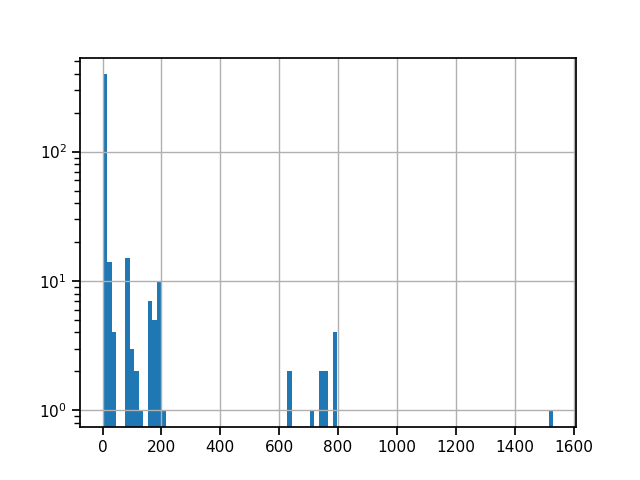

In [ ]:
merged.minimal_distance.hist(log=True, bins=100)

In [ ]:
merged.loc[merged.minimal_distance > 50, "geopy_names"] = "unknown"

In [ ]:
merged.groupby("geopy_names").size()

geopy_names
Albany                    5
Atka                      3
Bilbao                   12
Binghamton                2
BuenosAires              14
Caterpillar               9
Cortland                  1
Geneseo                   1
Giza                     35
Halifax                   3
Inca_City                30
Inca_City_Ridges         33
Ithaca                   50
Macclesfield             35
Manhattan2               11
Manhattan_Classic        50
Manhattan_Cracks         13
Manhattan_Frontinella    21
Oswego_Edge              20
Pisaq                     5
Portsmouth               11
Potsdam                  17
Rochester                 4
Schenectady               9
Starburst                12
Troy                      5
Wellington                2
unknown                  56
dtype: int64

In [ ]:
merged = merged.merge(
    meta[["OBSERVATION_START_TIME", "OBSERVATION_ID"]],
    left_on="obsid",
    right_on="OBSERVATION_ID",
).drop("OBSERVATION_ID", axis=1)

In [ ]:
merged.rename({"OBSERVATION_START_TIME": "time"}, axis=1, inplace=True)

In [ ]:
merged.head(20)

,obsid,lat_IND,lon_IND,geopy_names,minimal_distance,lat_WORD,lon_WORD,time
0,ESP_012079_0945,-85.4074,103.97,Macclesfield,0.944588,-85.401,103.901,2009-02-22 16:32:19
1,ESP_021494_0945,-85.4041,103.943,Macclesfield,0.511133,-85.401,103.901,2011-02-26 07:30:27
2,ESP_011407_0945,-85.4065,103.983,Macclesfield,0.957066,-85.401,103.901,2009-01-01 07:49:15
3,ESP_020782_0945,-85.4071,103.967,Macclesfield,0.901696,-85.401,103.901,2011-01-01 19:57:51
4,ESP_020716_0945,-85.4086,103.979,Macclesfield,1.098928,-85.401,103.901,2010-12-27 16:32:24
5,ESP_020571_0945,-85.4082,103.976,Macclesfield,1.047418,-85.401,103.901,2010-12-16 09:22:25
6,ESP_011723_0945,-85.4056,103.949,Macclesfield,0.669740,-85.401,103.901,2009-01-25 22:46:54
7,ESP_011934_0945,-85.4049,103.948,Macclesfield,0.605596,-85.401,103.901,2009-02-11 09:22:23
8,ESP_020294_0945,-85.4109,103.989,Macclesfield,1.357323,-85.401,103.901,2010-11-24 19:20:25
9,ESP_020927_0945,-85.4075,103.966,Macclesfield,0.930270,-85.401,103.901,2011-01-13 03:07:18


In [ ]:
merged.query("geopy_names == 'Ithaca'")

,obsid,lat_IND,lon_IND,geopy_names,minimal_distance,lat_WORD,lon_WORD,time
129,ESP_011931_0945,-85.21,181.482,Ithaca,11.746301,-85.128,180.7,2009-02-11 03:45:54
130,ESP_012063_0945,-85.2101,181.495,Ithaca,11.831857,-85.128,180.7,2009-02-21 10:37:04
131,ESP_020357_0950,-85.134,180.716,Ithaca,0.687067,-85.128,180.7,2010-11-29 17:09:47
132,ESP_011350_0945,-85.216,181.415,Ithaca,11.906675,-85.128,180.7,2008-12-27 21:14:00
133,ESP_020476_0950,-85.1381,180.778,Ithaca,1.348618,-85.128,180.7,2010-12-08 23:42:40
134,ESP_021491_0950,-85.1591,180.857,Ithaca,3.777379,-85.128,180.7,2011-02-26 01:54:01
135,ESP_020779_0950,-85.1362,180.735,Ithaca,0.974052,-85.128,180.7,2011-01-01 14:21:25
136,ESP_012076_0945,-85.2099,181.47,Ithaca,11.667244,-85.128,180.7,2009-02-22 10:55:51
137,ESP_012643_0945,-85.2084,181.465,Ithaca,11.507606,-85.128,180.7,2009-04-07 15:16:44
138,ESP_020146_0950,-85.1347,180.721,Ithaca,0.774321,-85.128,180.7,2010-11-13 06:33:03


In [ ]:
from planet4 import stats

In [ ]:
stats.define_martian_year(merged, "time")

In [ ]:
merged.MY.value_counts()

28    166
29    129
30     92
31     41
32     28
33     13
Name: MY, dtype: int64

In [ ]:
merged.shape

(469, 9)

In [ ]:
merged.to_csv(Path.home() / "Dropbox/data/planet4/p4_analysis/obsid_region_names.csv",
    index=False,
)

In [ ]:
pd.set_option("display.max_rows", 100)

In [ ]:
merged = merged[merged.geopy_names != "unknown"]

In [ ]:
merged["MY"].value_counts()

29    126
28    113
30     92
31     41
32     28
33     13
Name: MY, dtype: int64

In [ ]:
merged["MY28"] = merged.MY == 28

In [ ]:
hirise_data = merged.groupby(["geopy_names", "MY"]).size().unstack("MY")

In [ ]:
to_plot2 = merged.groupby(["geopy_names", "MY"]).size().unstack("MY")

In [ ]:
hirise_data.fillna(0).astype("int").to_csv(
    "/Users/klay6683/Dropbox/SternchenAndMe/proposals/2019-11-20-MDAP-P4/all_hirise_data.csv"
)

In [ ]:
merged.loc[merged.geopy_names == "unknown"].MY.value_counts()

28    51
29     3
Name: MY, dtype: int64

In [ ]:
merged[merged.geopy_names == "unknown"][["lat_IND", "lon_IND", "MY"]]

,lat_IND,lon_IND,MY
14,-84.2131,118.5620,28
16,-84.5605,119.1830,28
19,-84.5618,119.2030,28
26,-84.6815,118.6010,28
29,-84.6916,118.5470,28
30,-84.6947,118.5780,28
31,-84.5610,119.1810,28
33,-84.5473,119.1050,28
35,-84.6301,117.3430,28
48,-82.5135,80.0473,29


In [ ]:
to_plot = to_plot[to_plot.MY < 33]

In [ ]:
merged[merged.geopy_names == "unknown"][
    ["MY", "obsid", "lat_IND", "lon_IND"]
].to_csv("unknowns.csv", index=False)

In [ ]:
to_plot.columns = ["name", "MY", "count"]

In [ ]:
to_plot2.head()

MY,28,29,30,31,32
geopy_names,,,,,
Albany,NaN,5.0,NaN,NaN,NaN
Atka,NaN,3.0,NaN,NaN,NaN
Bilbao,2.0,7.0,3.0,NaN,NaN
Binghamton,NaN,2.0,NaN,NaN,NaN
BuenosAires,NaN,7.0,7.0,NaN,NaN


In [ ]:
to_plot2 = to_plot2.reset_index()

In [ ]:
to_plot2[to_plot2.index=='unknown']

KeyError: False

In [ ]:
to_plot2 = to_plot2[to_plot2.geopy_names!='unknown']

In [ ]:
to_plot2.get(['Caterpillar', 29])

In [ ]:
to_plot2.set_index('geopy_names').at['Caterpillar', 28]

In [ ]:
to_plot2.loc[to_plot2.geopy_names'Albany', 29]

In [ ]:
for name in indexed.index:
    print(name)

In [ ]:
indexed.at['Starburst', 28]

In [ ]:
f, axes = plt.subplots(1, 5, figsize=(6,6), sharey=True,
                       constrained_layout=True)

indexed = to_plot2.set_index('geopy_names')

for yr,ax in zip(range(28,33), axes):
    g = sns.barplot(x=yr, y='geopy_names', ax=ax, data=to_plot2)
    ax.set_ylabel('')
    
#     for name in indexed.index:
#         s = indexed.at[name, yr]
#         ax.text(s, name, s);

In [ ]:
for_table = to_plot2.set_index('geopy_names')

In [ ]:
for_table.index.name="ROI"

In [ ]:
for_table.to_csv("dataset_table.csv")

In [ ]:
merged.shape

In [ ]:
to_plot2 = to_plot2.fillna(0).astype('int')

In [ ]:
sns.countplot(x='MY', y='geopy_names', data=to_plot)

In [ ]:
region_names.set_index('name').drop('point', axis=1).join(for_table).to_csv("dataset_table.csv")

In [ ]:
for_table.join(region_names.set_index('name'))

In [ ]:
merged.time.max()

In [ ]:
to_plot

In [ ]:
!ls *.csv

In [ ]:
status = pd.read_csv("current_status.csv", header=None)

In [ ]:
status.columns = ['obsid', 'done']

In [ ]:
merged.columns

In [ ]:
newmerge = merged.merge(status, on='obsid')

In [ ]:
newmerge[newmerge.done < 25].geopy_names.value_counts()

In [ ]:
import qgrid

# P4 catalog stats

In [ ]:
fans = pd.read_csv(
    "/Users/klay6683/Dropbox/data/planet4/p4_analysis/P4_catalog_v1.1/P4_catalog_v1.1_L1C_cut_0.5_fan.csv"
)

In [ ]:
fans.head()

,marking_id,angle,distance,tile_id,image_x,image_y,n_votes,obsid,spread,version,...,y_angle,l_s,map_scale,north_azimuth,BodyFixedCoordinateX,BodyFixedCoordinateY,BodyFixedCoordinateZ,PlanetocentricLatitude,PlanetographicLatitude,Longitude
0,F000000,205.56,179.71,APF0000ci9,2270.76,24336.16,35,ESP_012079_0945,88.03,1,...,-0.43,214.785,0.25,126.856883,-65.804336,261.407884,-3370.504345,-85.427383,-85.480829,104.129523
1,F000001,185.39,179.62,APF0000cia,3391.21,5640.60,15,ESP_012079_0945,21.35,1,...,-0.09,214.785,0.25,126.856883,-67.219114,257.011589,-3370.631413,-85.493546,-85.546226,104.656897
2,F000002,184.98,500.27,APF0000cia,3509.96,5876.70,10,ESP_012079_0945,18.91,1,...,-0.09,214.785,0.25,126.856883,-67.170611,257.055226,-3370.630794,-85.493039,-85.545725,104.644396
3,F000004,184.29,105.43,APF0000cia,3716.27,5824.50,6,ESP_012079_0945,26.41,1,...,-0.07,214.785,0.25,126.856883,-67.127761,257.024926,-3370.635002,-85.493723,-85.546401,104.637107
4,F000005,189.42,109.50,APF0000cia,3452.17,6033.00,3,ESP_012079_0945,22.58,1,...,-0.16,214.785,0.25,126.856883,-67.169940,257.096267,-3370.628302,-85.492368,-85.545061,104.642019


In [ ]:
fans.groupby("obsid").size().sort_values(ascending=False).head()

obsid
ESP_012316_0925    12304
ESP_012527_0925    10918
ESP_011960_0925     6737
ESP_021520_0925     6585
ESP_021454_0925     6514
dtype: int64

In [ ]:
fans.groupby("obsid").size().mean()

737.0976744186047

In [ ]:
blotches = pd.read_csv(
    "/Users/klay6683/Dropbox/data/planet4/p4_analysis/P4_catalog_v1.1/P4_catalog_v1.1_L1C_cut_0.5_blotch.csv"
)

In [ ]:
blotches.groupby("obsid").size().sort_values(ascending=False).head()

obsid
ESP_012604_0965    20916
ESP_012314_0965    20094
ESP_012248_0965    19264
ESP_012393_0965     9978
ESP_011680_1055     7102
dtype: int64

In [ ]:
blotches.groupby("obsid").size().mean()

1130.3212669683257